# 1. Data Gathering

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
data = pd.read_csv('spam.csv',encoding='latin-1')

data = data.drop(["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], axis=1)
data = data.rename(columns={"v1":'label', "v2":'text'})
print(data.head())
tags = data["label"]
texts = data["text"]

  label                                               text
0   ham  Go until jurong point, crazy.. Available only ...
1   ham                      Ok lar... Joking wif u oni...
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...
3   ham  U dun say so early hor... U c already then say...
4   ham  Nah I don't think he goes to usf, he lives aro...


### To do: develop an accurate simple neural network model for spam classification (no LSTM, CNN, etc.)

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
%matplotlib inline
# library for train test split
from sklearn.model_selection import train_test_split
# deep learning libraries for text pre-processing
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
# Modeling 
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D, Dense, Dropout, LSTM, Bidirectional

# 2. Data Analysis

In [3]:
data.describe()

,label,text
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


In [4]:
duplicatedRow = data[data.duplicated()]
print(duplicatedRow[:5])

    label                                               text
102   ham  As per your request 'Melle Melle (Oru Minnamin...
153   ham  As per your request 'Melle Melle (Oru Minnamin...
206   ham  As I entered my cabin my PA said, '' Happy B'd...
222   ham                             Sorry, I'll call later
325   ham                   No calls..messages..missed calls


In [5]:
data.groupby('label').describe().T

label                           ham  \
text count                     4825   
     unique                    4516   
     top     Sorry, I'll call later   
     freq                        30   

label                                                     spam  
text count                                                 747  
     unique                                                653  
     top     Please call our customer service representativ...  
     freq                                                    4

In [6]:
# Get all the ham and spam emails
ham_msg = data[data.label =='ham']
spam_msg = data[data.label=='spam']
# Create numpy list to visualize using wordcloud
ham_msg_text = " ".join(ham_msg.text.to_numpy().tolist())
spam_msg_text = " ".join(spam_msg.text.to_numpy().tolist())

To visualize the frequency of text in hams and spams, wordcloud is used.

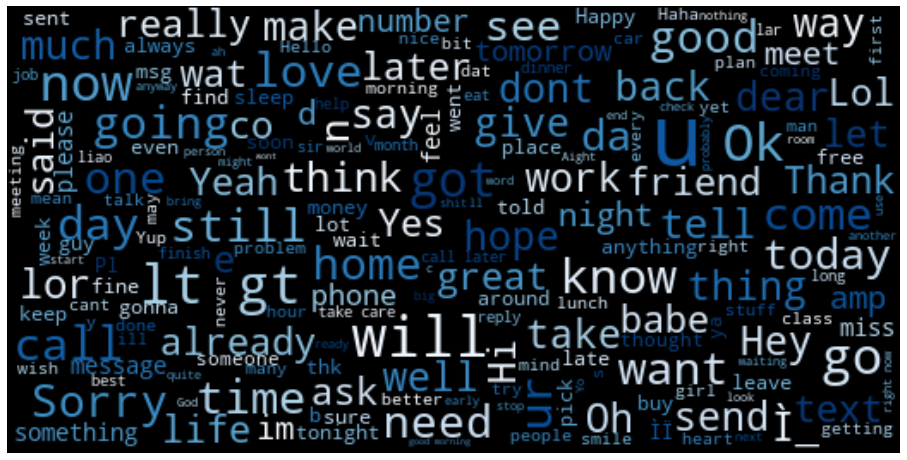

In [7]:
# wordcloud of ham messages
ham_msg_cloud = WordCloud(width =520, height =260, stopwords=STOPWORDS,max_font_size=50, background_color ="black", colormap='Blues').generate(ham_msg_text)
plt.figure(figsize=(16,10))
plt.imshow(ham_msg_cloud, interpolation='bilinear')
plt.axis('off') # turn off axis
plt.show()

The wordcloud for hams shows words that are normally used in messaging.

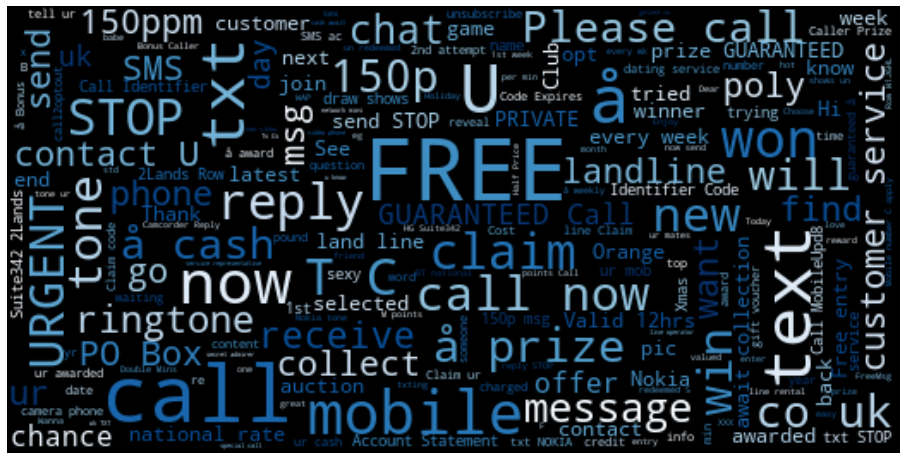

In [8]:
# wordcloud of spam messages
spam_msg_cloud = WordCloud(width =520, height =260, stopwords=STOPWORDS,max_font_size=50, background_color ="black", colormap='Blues').generate(spam_msg_text)
plt.figure(figsize=(16,10))
plt.imshow(spam_msg_cloud, interpolation='bilinear')
plt.axis('off') # turn off axis
plt.show()

The wordcloud for spams shows texts that are seen in advertisements as well as scam messages.

C:\Users\kylle\miniconda3\envs\myenv2\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


15.481865284974095

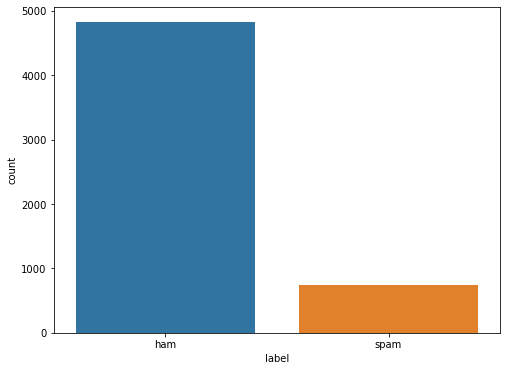

In [9]:
# we can observe imbalance data here 
plt.figure(figsize=(8,6))
sns.countplot(data.label)
# Percentage of spam messages
(len(spam_msg)/len(ham_msg))*100 # 15.48%

A visualization about the volume and ratio of both outputs.

In [10]:
# one way to fix it is to downsample the ham msg
ham_msg_df = ham_msg.sample(n = len(spam_msg), random_state = 44)
# The code removes ham msg from the sample randomnly until there are only as much ham as spams.
spam_msg_df = spam_msg
print(ham_msg_df.shape, spam_msg_df.shape)


(747, 2) (747, 2)


C:\Users\kylle\AppData\Local\Temp\ipykernel_8020\2456489486.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  msg_df = ham_msg_df.append(spam_msg_df).reset_index(drop=True)
C:\Users\kylle\miniconda3\envs\myenv2\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


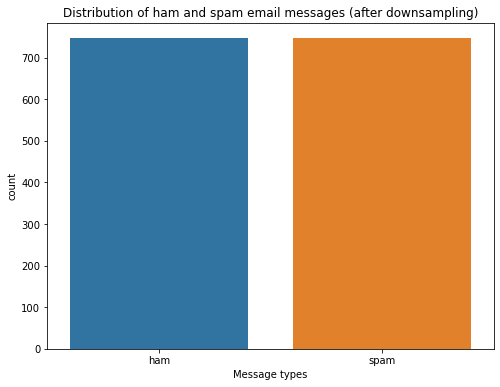

In [11]:
# Create a dataframe with these ham and spam msg
msg_df = ham_msg_df.append(spam_msg_df).reset_index(drop=True)
# Combines both ham and spam into a single dataframe for modelling
plt.figure(figsize=(8,6))
sns.countplot(msg_df.label)
plt.title('Distribution of ham and spam email messages (after downsampling)')
plt.xlabel('Message types')
plt.show()

Data visualization of ham and spam after downsampling in order to have a better testing and training dataset.

In [12]:
# Get length column for each text
msg_df['text_length'] = msg_df['text'].apply(len)
# Creates a dataframe that contains the amount of text per entry on msg_df
#Calculate average length by label types using mean
labels = msg_df.groupby('label').mean()
labels

,text_length
label,
ham,69.626506
spam,138.866131


 Shows the average text length for ham and spam

In [13]:
# Map ham label as 0 and spam as 1
msg_df['msg_type']= msg_df['label'].map({'ham': 0, 'spam': 1})
msg_label = msg_df['msg_type'].values
# Split data into train and test
train_msg, test_msg, train_labels, test_labels = train_test_split(msg_df['text'], msg_label, test_size=0.2, random_state=123)
# 80-20 split 

In [14]:
msg_df

,label,text,text_length,msg_type
0,ham,"Yes, princess. Toledo.",22,0
1,ham,Dude while were makin those weirdy brownies my...,88,0
2,ham,"Hiya, sorry didn't hav signal. I haven't seen ...",169,0
3,ham,Then u ask darren go n pick u lor... But i oso...,74,0
4,ham,Lol no. I just need to cash in my nitros. Hurr...,75,0
...,...,...,...,...
1489,spam,Want explicit SEX in 30 secs? Ring 02073162414...,90,1
1490,spam,ASKED 3MOBILE IF 0870 CHATLINES INCLU IN FREE ...,160,1
1491,spam,Had your contract mobile 11 Mnths? Latest Moto...,160,1
1492,spam,REMINDER FROM O2: To get 2.50 pounds free call...,147,1


In [15]:
# Defining pre-processing hyperparameters
max_len = 50 
trunc_type = "post" 
padding_type = "post" 
oov_tok = "<OOV>" 
vocab_size = 500
# trunc type and padding type post means that whenever the limit is reached 
# oov token means words that are out of our vocabulary if there are such words it is then inserted to this storage

In [16]:
tokenizer = Tokenizer(num_words = vocab_size, char_level=False, oov_token = oov_tok)
tokenizer.fit_on_texts(train_msg)


In [17]:
# Get the word_index 
word_index = tokenizer.word_index
word_index

{'<OOV>': 1,
 'to': 2,
 'you': 3,
 'a': 4,
 'i': 5,
 'the': 6,
 'call': 7,
 'your': 8,
 'u': 9,
 'for': 10,
 'is': 11,
 'free': 12,
 'and': 13,
 'now': 14,
 'in': 15,
 '2': 16,
 'have': 17,
 'or': 18,
 'ur': 19,
 'on': 20,
 'of': 21,
 'txt': 22,
 'with': 23,
 '4': 24,
 'me': 25,
 'are': 26,
 'from': 27,
 'get': 28,
 'my': 29,
 'text': 30,
 'mobile': 31,
 'stop': 32,
 'this': 33,
 'just': 34,
 'be': 35,
 'reply': 36,
 'only': 37,
 'claim': 38,
 'no': 39,
 'it': 40,
 'that': 41,
 'send': 42,
 'www': 43,
 'we': 44,
 'so': 45,
 'out': 46,
 'at': 47,
 'our': 48,
 'will': 49,
 'prize': 50,
 'can': 51,
 'do': 52,
 'if': 53,
 'won': 54,
 'new': 55,
 'cash': 56,
 'not': 57,
 'please': 58,
 '150p': 59,
 'up': 60,
 'week': 61,
 'who': 62,
 'want': 63,
 'know': 64,
 'nokia': 65,
 't': 66,
 'go': 67,
 'uk': 68,
 'msg': 69,
 '1': 70,
 'but': 71,
 'all': 72,
 'win': 73,
 'by': 74,
 "i'm": 75,
 'gt': 76,
 'lt': 77,
 'tone': 78,
 'been': 79,
 '18': 80,
 'good': 81,
 'love': 82,
 '50': 83,
 'phone': 84,

In [18]:
# check how many words 
tot_words = len(word_index)
print('There are %s unique tokens in training data. ' % tot_words)

There are 4117 unique tokens in training data. 


In [19]:
# Sequencing and padding on training and testing 
training_sequences = tokenizer.texts_to_sequences(train_msg)
training_padded = pad_sequences (training_sequences, maxlen = max_len, padding = padding_type, truncating = trunc_type )
testing_sequences = tokenizer.texts_to_sequences(test_msg)
testing_padded = pad_sequences(testing_sequences, maxlen = max_len,
padding = padding_type, truncating = trunc_type)

In [20]:
# Shape of train tensor
print('Shape of training tensor: ', training_padded.shape)
print('Shape of testing tensor: ', testing_padded.shape)

Shape of training tensor:  (1195, 50)
Shape of testing tensor:  (299, 50)


In [21]:
# Before padding
len(training_sequences[0]), len(training_sequences[1])

(29, 9)

In [22]:
# After padding
len(training_padded[0]), len(training_padded[1])
# The rest are filled so that training a model is easier. 
# The zeroes are at the last part since the padding type is set to 'post'

(50, 50)

In [23]:
print(training_padded[0])
# A sample of a sentence on array[0] the numbers represents the token

[ 29   1   1  41   1  11   1  10  72 364   1   1   1  45  40  49  35   1
  10   3 113 202   7   1   1   1  13   1  40   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]


In [24]:
vocab_size = 500 # As defined earlier
embeding_dim = 16
drop_value = 0.2 # dropout
n_dense = 24
# Parameters used for modelling

In [25]:
# Keras Model
model = Sequential()
model.add(Embedding(vocab_size, embeding_dim, input_length=max_len))
model.add(GlobalAveragePooling1D())
# Global pooling allows the model to create a feature map for each classification
model.add(Dense(24, activation='relu'))
model.add(Dropout(drop_value))
# Droupout prevents overfitting
model.add(Dense(1, activation='sigmoid'))

In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 16)            8000      
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 24)                408       
_________________________________________________________________
dropout (Dropout)            (None, 24)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 25        
Total params: 8,433
Trainable params: 8,433
Non-trainable params: 0
_________________________________________________________________


In [27]:
model.compile(loss='binary_crossentropy',optimizer='adam' ,metrics=['accuracy'])

In [28]:
# fitting a dense spam detector model
num_epochs = 30
early_stop = EarlyStopping(monitor='val_loss', patience=3)
# Early stopping enables you to monitor a certain value, in this case the validation loss
# It minimizes loss allowing you to have a model with less loss.
history = model.fit(training_padded, train_labels, epochs=num_epochs, validation_data=(testing_padded, test_labels),callbacks =[early_stop], verbose=2)

Epoch 1/30
38/38 - 1s - loss: 0.6848 - accuracy: 0.5448 - val_loss: 0.6755 - val_accuracy: 0.6054
Epoch 2/30
38/38 - 0s - loss: 0.6597 - accuracy: 0.7782 - val_loss: 0.6394 - val_accuracy: 0.8528
Epoch 3/30
38/38 - 0s - loss: 0.6073 - accuracy: 0.8510 - val_loss: 0.5689 - val_accuracy: 0.8763
Epoch 4/30
38/38 - 0s - loss: 0.5266 - accuracy: 0.8753 - val_loss: 0.4802 - val_accuracy: 0.8829
Epoch 5/30
38/38 - 0s - loss: 0.4338 - accuracy: 0.8879 - val_loss: 0.3900 - val_accuracy: 0.9130
Epoch 6/30
38/38 - 0s - loss: 0.3562 - accuracy: 0.9054 - val_loss: 0.3214 - val_accuracy: 0.9164
Epoch 7/30
38/38 - 0s - loss: 0.2980 - accuracy: 0.9096 - val_loss: 0.2688 - val_accuracy: 0.9298
Epoch 8/30
38/38 - 0s - loss: 0.2540 - accuracy: 0.9255 - val_loss: 0.2320 - val_accuracy: 0.9298
Epoch 9/30
38/38 - 0s - loss: 0.2213 - accuracy: 0.9364 - val_loss: 0.2037 - val_accuracy: 0.9331
Epoch 10/30
38/38 - 0s - loss: 0.1853 - accuracy: 0.9448 - val_loss: 0.1806 - val_accuracy: 0.9498
Epoch 11/30
38/38 -

The epoch was cut at 28 since the patience level was reached and a desired accuracy and validation loss was achieved

In [29]:
# Model performance on test data 
model.evaluate(testing_padded, test_labels)

10/10 [==============================] - 0s 667us/step - loss: 0.1178 - accuracy: 0.9666


[0.11779827624559402, 0.9665551781654358]

An accuracy of 96.65% was achieved after training the dense model

In [30]:
# Read as a dataframe 
metrics = pd.DataFrame(history.history)
metrics.rename(columns = {'loss': 'Training_Loss', 'accuracy': 'Training_Accuracy', 'val_loss': 'Validation_Loss', 'val_accuracy': 'Validation_Accuracy'}, inplace = True)
# Graph for training and validation accuracy along all the epochs
def plot_graphs1(var1, var2, string):
    metrics[[var1, var2]].plot()
    plt.title('Training and Validation ' + string)
    plt.xlabel ('Number of epochs')
    plt.ylabel(string)
    plt.legend([var1, var2])

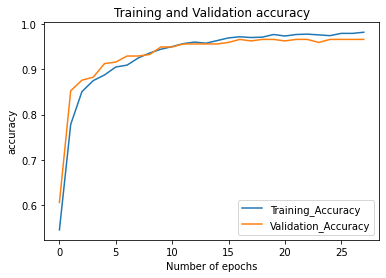

In [31]:
plot_graphs1('Training_Accuracy', 'Validation_Accuracy', 'accuracy')
# A graph that shows that the model is not overfitted since an overfitted model
# tend to show on this type of plot.

In [36]:
# display test dataframe data
testdf = pd.read_csv('output_spam.csv')
# reads the csv file that tests the model with new data
pd.options.display.max_colwidth=100
# Allows 100 characters to be displayed which is in the text column
testdf

,Unnamed: 0,text
0,1,Feel Yourself That You Are Always Happy.. Slowly It Becomes Your Habit &amp; Finally It Becomes ...
1,2,staff.science.nus.edu.sg/~phyhcmk/teaching/pc1323
2,3,Send me yetty's number pls.
3,4,Hey so this sat are we going for the intro pilates only? Or the kickboxing too?
4,5,I got it before the new year cos yetunde said she wanted to surprise you with it but when i didn...
5,6,Hey we can go jazz power yoga hip hop kb and yogasana
6,7,Hey mate. Spoke to the mag people. We‰Û÷re on. the is deliver by the end of the month. Deliver ...
7,8,Morning only i can ok.
8,9,Wat time Ì_ finish?
9,10,Shant disturb u anymore... Jia you...


In [33]:
predict_msg = testdf['text'].values.tolist()
# converts dataframe to list in the testdf for prediction

In [34]:
# A function for prediction, converts the predict_msg to tokens
# Similar to what was implemented earlier so that the model will understand
def predict_spam(predict_msg):
    new_seq = tokenizer.texts_to_sequences(predict_msg)
    padded = pad_sequences(new_seq, maxlen =max_len,
                      padding = padding_type,
                      truncating=trunc_type)
    return (model.predict(padded))
# The nature of the model shows probability that the prediction is a spam
# Set a value >0.5 so that if the probability is greater than 50%
# then the message is 50% or greater likely to be spam
testingpred = (predict_spam(predict_msg) > 0.5).astype('int32').tolist()

In [37]:
print(testingpred)
# prints the testing pred for the test df which spam_output csv

[[0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [1], [1], [0], [1], [0], [0], [0], [0], [0], [0]]
